# Building a Neural Language Model 
Following [Bengio et al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Architecture

The architecture of the MLP we'll be building in this notebook

![hello](neural_probabalistic_language_model_architecture.png "MLP Architecture")

In [3]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset

block_size = 3
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


From just 5 words we can create a dataset of 32 examples using `.` as padding characters.

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
# We now initialise the Tensor for each character in our vocabulary (27) and it's corresponding embedding.
# For now in 2D as we only have 27 characters
# In Bengio et al, they had 17,000 words and embedded in as small as a 30 dimensional space
C = torch.randn((27, 2))
C

tensor([[ 0.2846,  0.8090],
        [-0.0852,  0.1523],
        [ 0.3026, -1.3077],
        [ 2.0747, -2.2329],
        [ 0.3378, -0.8576],
        [-0.4134,  0.0232],
        [ 0.6042,  1.4034],
        [-0.5635,  1.6117],
        [ 0.4078, -0.1359],
        [ 0.0292, -1.0447],
        [-2.3062, -0.4492],
        [ 0.8876,  0.6502],
        [-0.3900, -0.5318],
        [ 0.7190, -0.2318],
        [ 0.3977,  0.5080],
        [-1.0440,  1.5541],
        [-0.1877, -1.2109],
        [-0.1427,  2.0711],
        [ 1.1934, -0.3398],
        [ 0.5220, -1.3013],
        [-0.3804,  0.5429],
        [ 0.9313,  0.2064],
        [ 0.7354, -1.0927],
        [-2.0176, -2.5494],
        [-0.2303,  1.1224],
        [-0.0456, -0.9769],
        [-0.7051, -0.2192]])

Let's try and embed a single integer first

In [10]:
# for 5:
C[5]

tensor([-0.4134,  0.0232])

In [11]:
# Using one-hot ecoding
# F.one_hot(5, num_classes=27) # Doesn't work, needs to be a tensor
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [12]:
# Doesn't work since the onehot encoded 
# F.one_hot(torch.tensor(5), num_classes=27) @ C
# RuntimeError: expected m1 and m2 to have the same dtype, but got: long long != float

In [13]:
# PyTorch needs to have a float Tensor to know how to multiply with another float Tensor
# self.long() is equivalent to self.to(torch.int64).
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4134,  0.0232])

We get the same embedding as before when we grabbed the 5th index of the Tensor C. 

Therefore in the lookup table highlighted below, we can retrieve the embedding for a character/word/token either by indexing into the tensor of embeddings or by one-hot encoding the vocabulary and then doing an efficient matrix multiplication.

![asd](neural_probabalistic_language_model_architecture_lookup_table.png "Character lookup table")

Here we will index as it is much faster and use a character table.

In [14]:
# We can also index with a list or tensor
C[[5, 6, 7]]

tensor([[-0.4134,  0.0232],
        [ 0.6042,  1.4034],
        [-0.5635,  1.6117]])

In [15]:
C[torch.tensor([5, 6, 7, 7, 7, 7, 7])] # Adding the same index will replicate it multiple times

tensor([[-0.4134,  0.0232],
        [ 0.6042,  1.4034],
        [-0.5635,  1.6117],
        [-0.5635,  1.6117],
        [-0.5635,  1.6117],
        [-0.5635,  1.6117],
        [-0.5635,  1.6117]])

We can also index with a multi-dimensional tensor like out input data `X`

In [16]:
C[X].shape, C[X]

(torch.Size([32, 3, 2]),
 tensor([[[ 0.2846,  0.8090],
          [ 0.2846,  0.8090],
          [ 0.2846,  0.8090]],
 
         [[ 0.2846,  0.8090],
          [ 0.2846,  0.8090],
          [-0.4134,  0.0232]],
 
         [[ 0.2846,  0.8090],
          [-0.4134,  0.0232],
          [ 0.7190, -0.2318]],
 
         [[-0.4134,  0.0232],
          [ 0.7190, -0.2318],
          [ 0.7190, -0.2318]],
 
         [[ 0.7190, -0.2318],
          [ 0.7190, -0.2318],
          [-0.0852,  0.1523]],
 
         [[ 0.2846,  0.8090],
          [ 0.2846,  0.8090],
          [ 0.2846,  0.8090]],
 
         [[ 0.2846,  0.8090],
          [ 0.2846,  0.8090],
          [-1.0440,  1.5541]],
 
         [[ 0.2846,  0.8090],
          [-1.0440,  1.5541],
          [-0.3900, -0.5318]],
 
         [[-1.0440,  1.5541],
          [-0.3900, -0.5318],
          [ 0.0292, -1.0447]],
 
         [[-0.3900, -0.5318],
          [ 0.0292, -1.0447],
          [ 0.7354, -1.0927]],
 
         [[ 0.0292, -1.0447],
          [ 0.7

In [17]:
X[13, 2]

tensor(1)

In [18]:
C[X][13, 2]

tensor([-0.0852,  0.1523])

In [19]:
C[1]

tensor([-0.0852,  0.1523])

Therefore we can easily embed all of the input data X by using C[X]

In [20]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [21]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [22]:
# The below doesn't work since emb has shape 32x3x2 and W1 has shape 6x100
# emb @ W1 + b1 
# How do we transform this so that it does work?

So we now need to concatenate the embeddings for each of the context words together to pass through the network.

![ads](neural_probabalistic_language_model_architecture_input_embeddings.png "Input embeddings")

To do this, we can use efficient PyTorch concatenating

In [23]:
emb.shape

torch.Size([32, 3, 2])

1st dimension 32 = number of input examples

2nd dimension 3 = context size (words in the context of the network)

3rd dimension 2 = dimensionality of the embeddings

We need to concatenate the inputs together effectively eliminating the 2nd dimension above, so that the final dimension is 36x6 - since 2 is the embedding size

In [24]:
torch.concat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], axis=1).shape

torch.Size([32, 6])

However there is a more efficient way to do this concatenation. Currently the context window (3) dictates the code above, but we can use [torch.unbind](https://docs.pytorch.org/docs/stable/generated/torch.unbind.html) to unbind a dimension of a tensor and effectively concatenate the tensor along a given axis.

*Returns a tuple of all slices along a given dimension, already without it.*

In [25]:
str(type(torch.unbind(emb, 1))) + " of " + str(type(torch.unbind(emb, 1)[0])) + "s", "Length: " + str(len(torch.unbind(emb, 1))), 

("<class 'tuple'> of <class 'torch.Tensor'>s", 'Length: 3')

In [27]:
# So we can now concat the tuple of tensors into a single concatenated tensor
torch.concat(torch.unbind(emb, 1), axis=1).shape, torch.concat(torch.unbind(emb, 1), axis=1)

(torch.Size([32, 6]),
 tensor([[ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
         [ 0.2846,  0.8090,  0.2846,  0.8090, -0.4134,  0.0232],
         [ 0.2846,  0.8090, -0.4134,  0.0232,  0.7190, -0.2318],
         [-0.4134,  0.0232,  0.7190, -0.2318,  0.7190, -0.2318],
         [ 0.7190, -0.2318,  0.7190, -0.2318, -0.0852,  0.1523],
         [ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
         [ 0.2846,  0.8090,  0.2846,  0.8090, -1.0440,  1.5541],
         [ 0.2846,  0.8090, -1.0440,  1.5541, -0.3900, -0.5318],
         [-1.0440,  1.5541, -0.3900, -0.5318,  0.0292, -1.0447],
         [-0.3900, -0.5318,  0.0292, -1.0447,  0.7354, -1.0927],
         [ 0.0292, -1.0447,  0.7354, -1.0927,  0.0292, -1.0447],
         [ 0.7354, -1.0927,  0.0292, -1.0447, -0.0852,  0.1523],
         [ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
         [ 0.2846,  0.8090,  0.2846,  0.8090, -0.0852,  0.1523],
         [ 0.2846,  0.8090, -0.0852,  0.1523,  0.7354, -1.0927],
   

But there is an even MORE efficient way...

In [28]:
# For a
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [29]:
# we can use torch.tensor.view here to reframe this as a specific shape
# As long as the total number of elements multiply to be the same, this will work
# This operation is extremely efficient in PyTorch
a.view(3, 3, 2), a.view(3, 6), a.view(1, 1, 1, 18)

(tensor([[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],
 
         [[ 6,  7],
          [ 8,  9],
          [10, 11]],
 
         [[12, 13],
          [14, 15],
          [16, 17]]]),
 tensor([[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17]]),
 tensor([[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17]]]]))

In [30]:
# This is due to the inner workings of PyTorch which mean 
# each tensor is actually stored as a 1D array in memory
a.storage()

/var/folders/2k/_76yvmn57bn1476p8q_sh4000000gp/T/ipykernel_27984/1869348551.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [31]:
# To get a storage without the dtype
a.untyped_storage()

 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 2
 0
 0
 0
 0
 0
 0
 0
 3
 0
 0
 0
 0
 0
 0
 0
 4
 0
 0
 0
 0
 0
 0
 0
 5
 0
 0
 0
 0
 0
 0
 0
 6
 0
 0
 0
 0
 0
 0
 0
 7
 0
 0
 0
 0
 0
 0
 0
 8
 0
 0
 0
 0
 0
 0
 0
 9
 0
 0
 0
 0
 0
 0
 0
 10
 0
 0
 0
 0
 0
 0
 0
 11
 0
 0
 0
 0
 0
 0
 0
 12
 0
 0
 0
 0
 0
 0
 0
 13
 0
 0
 0
 0
 0
 0
 0
 14
 0
 0
 0
 0
 0
 0
 0
 15
 0
 0
 0
 0
 0
 0
 0
 16
 0
 0
 0
 0
 0
 0
 0
 17
 0
 0
 0
 0
 0
 0
 0
[torch.storage.UntypedStorage(device=cpu) of size 144]

So when we call view, we use the base data in memory without any other memory being changed, created, copied, or moved.

For more info on PyTorch internals see: [PyTorch internals blog post by Edward Zhang](https://blog.ezyang.com/2019/05/pytorch-internals/)

In [32]:
# Therefore we can now use view to efficiently convert this embedding of shape 32x3x2 to 32x6
emb.view(32,6)

tensor([[ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
        [ 0.2846,  0.8090,  0.2846,  0.8090, -0.4134,  0.0232],
        [ 0.2846,  0.8090, -0.4134,  0.0232,  0.7190, -0.2318],
        [-0.4134,  0.0232,  0.7190, -0.2318,  0.7190, -0.2318],
        [ 0.7190, -0.2318,  0.7190, -0.2318, -0.0852,  0.1523],
        [ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
        [ 0.2846,  0.8090,  0.2846,  0.8090, -1.0440,  1.5541],
        [ 0.2846,  0.8090, -1.0440,  1.5541, -0.3900, -0.5318],
        [-1.0440,  1.5541, -0.3900, -0.5318,  0.0292, -1.0447],
        [-0.3900, -0.5318,  0.0292, -1.0447,  0.7354, -1.0927],
        [ 0.0292, -1.0447,  0.7354, -1.0927,  0.0292, -1.0447],
        [ 0.7354, -1.0927,  0.0292, -1.0447, -0.0852,  0.1523],
        [ 0.2846,  0.8090,  0.2846,  0.8090,  0.2846,  0.8090],
        [ 0.2846,  0.8090,  0.2846,  0.8090, -0.0852,  0.1523],
        [ 0.2846,  0.8090, -0.0852,  0.1523,  0.7354, -1.0927],
        [-0.0852,  0.1523,  0.7354, -1.0

In [34]:
# Validate it's the same - each element is the exact same
torch.min(emb.view(32,6) == torch.concat(torch.unbind(emb, 1), axis=1)).item()

True

So we can now matrix multiply by W1

In [35]:
# Use emb.shape[0] here so we don't hardcode numbers, 
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [36]:
h.shape

torch.Size([32, 100])

In [68]:
# We can also use -1 and PyTorch will infer the shape of the first dimension 
# given the 2nd and the number of elements in the tensor
# We then take tanh of this to get the actual activation of h
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [70]:
h.shape, h

(torch.Size([32, 100]),
 tensor([[-0.6469,  0.3931,  0.9756,  ..., -0.8658,  0.8711,  0.8802],
         [ 0.4712, -0.9228, -0.2592,  ..., -0.6233,  0.9636,  0.6775],
         [-0.8646,  0.9362,  0.9987,  ..., -0.7553, -0.9728,  0.8887],
         ...,
         [-0.9310, -0.1602, -0.0467,  ...,  0.5952, -0.9024, -0.9956],
         [-0.7823,  0.9943,  0.9989,  ...,  0.2951,  0.0186,  0.9256],
         [-0.3503, -0.8617,  0.6816,  ..., -0.9997, -0.9976, -0.8481]]))

Let's now create W2 which is the 2nd layer and connects to the softmax.

This means we need to randomly initialise tensors with shape 100x27 - 100 for the 2nd dimension of the previous layer and 27 for the output layer/vocab size.

In [73]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [74]:
logits = h @ W2 + b2

In [78]:
logits.shape, logits

(torch.Size([32, 27]),
 tensor([[  4.7479,  -4.8214,  -4.2418,  -0.9037,  -5.2112,   5.0874,  19.4280,
           11.5557,   6.9428,  10.6885,  -5.7217, -14.1258,   0.0734,   7.7471,
            0.9540,   0.1288,   5.6584,  -1.1970,  -1.2563,   9.2051,   5.1186,
           -7.2555,  16.6380,   6.4098,  11.5524,   4.7040,  -8.1321],
         [  6.9868, -14.6423, -15.8826,   9.5805,   0.4531,   5.7056,   0.6700,
           10.0414,  -6.8170,  -4.7312,  -1.2775,  -3.8747, -16.6675,  -0.1132,
           -2.7757,   2.4756,  -0.3549,  -7.3674,  -8.7751,   4.3485,   0.8546,
            6.5615,   2.8454,  11.0407,   3.5510,   7.2049,  -4.0896],
         [ -9.3502,  14.4903,   6.8765, -10.4744,   2.0682,   0.6941,  -5.7586,
            0.2311, -10.1538,  12.7924,  10.2609, -10.9015,  -6.1698,  -2.5883,
           -2.4162,   7.4434,   7.3352,   9.7826,   2.1022,  -8.1759,   0.9470,
           -8.8057,   7.2497,  -7.5348,   3.3052, -10.4653,  10.2564],
         [  1.8301,   3.7334,   3.4163,  -0.

We then want to exponentiate these logits to get our 'fake counts' and then calculate the probability for each of the first dimension elements, as in the previous notebook when we were dealing with bi-grams.

In [79]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[3.9649e-07, 2.7690e-11, 4.9437e-11, 1.3924e-09, 1.8753e-11, 5.5677e-07,
         9.4127e-01, 3.5877e-04, 3.5603e-06, 1.5074e-04, 1.1255e-11, 2.5205e-15,
         3.6993e-09, 7.9574e-06, 8.9247e-09, 3.9102e-09, 9.8552e-07, 1.0385e-09,
         9.7866e-10, 3.4195e-05, 5.7444e-07, 2.4279e-12, 5.7813e-02, 2.0893e-06,
         3.5761e-04, 3.7945e-07, 1.0105e-12],
        [1.0468e-02, 4.2312e-12, 1.2242e-12, 1.4006e-01, 1.5217e-05, 2.9072e-03,
         1.8904e-05, 2.2206e-01, 1.0592e-08, 8.5272e-08, 2.6961e-06, 2.0082e-07,
         5.5840e-13, 8.6374e-06, 6.0267e-07, 1.1499e-04, 6.7827e-06, 6.1086e-09,
         1.4948e-09, 7.4831e-04, 2.2734e-05, 6.8419e-03, 1.6646e-04, 6.0320e-01,
         3.3706e-04, 1.3019e-02, 1.6198e-07],
        [3.6175e-11, 8.1697e-01, 4.0326e-04, 1.1754e-11, 3.2911e-06, 8.3293e-07,
         1.3129e-09, 5.2421e-07, 1.6196e-11, 1.4956e-01, 1.1896e-02, 7.6684e-12,
         8.7027e-10, 3.1267e-08, 3.7137e-08, 7.1084e-04, 6.3796e-04, 7.3737e-03,
         3.4051e-

So above we've calculated the output probabilities of each of the 27 characters and each of the 32 examples we inputted. Each tensor for each example should now sum to 1.

In [89]:
probs[0].sum().int().item()

1

Of course we have the actual letter that comes next from `Y`.

In [91]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [90]:
# Create an iterator over all 32 examples
# then index into each example and find the max prob
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [93]:
# We can then use PyTorch's tensor indexing to map all the indexes of the ground truth
# characters to their predicted probabilities from the network
probs[torch.arange(32), Y]

tensor([5.5677e-07, 8.6374e-06, 3.1267e-08, 8.9564e-09, 9.0375e-08, 3.9102e-09,
        9.4713e-13, 7.9872e-01, 3.9427e-10, 9.1185e-08, 1.7694e-04, 3.9765e-04,
        2.7690e-11, 1.0319e-03, 3.8037e-03, 9.0028e-06, 1.5074e-04, 9.7784e-05,
        1.4369e-06, 2.4776e-08, 4.0965e-06, 5.4026e-04, 6.0214e-01, 2.3527e-15,
        1.7052e-04, 3.4195e-05, 1.8886e-05, 2.7873e-05, 4.3605e-08, 1.8007e-06,
        6.6842e-05, 5.8407e-08])

In [95]:
# Therefore we can calculate the average negative log likelihood loss
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(13.3737)

## Combine everything above and make it *respectable*

In [102]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [103]:
sum(p.nelement() for p in parameters) # Total parameters of the network

3481

In [107]:
emb = C[X] # 32, 3, 2 - 32 X examples, 3 chars, with embedding of length 2
h = torch.tanh(emb.view(32, 6) @ W1 + b1) # 32, 100 - 32 examples, 3x2=6 concatenated embeddings of length 2 for each of the 3 chars
logits = h @ W2 + b2 # 32, 27 - 32 examples, 27 length of total volcabulary
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[np.arange(32), Y].log().mean()
loss

tensor(17.7697)

We could also just call the cross entropy loss from PyTorch which we have calculated above. This is much more efficient and reduces the amount of memory consumed when performing these operations. 

In [108]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [110]:
# To simplify
emb = C[X] # 32, 3, 2 - 32 X examples, 3 chars, with embedding of length 2
h = torch.tanh(emb.view(32, 6) @ W1 + b1) # 32, 100 - 32 examples, 3x2=6 concatenated embeddings of length 2 for each of the 3 chars
logits = h @ W2 + b2 # 32, 27 - 32 examples, 27 length of total volcabulary
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [115]:
logits = torch.tensor([-2 ,-3, 0, 100]) # Large positive numbers go to nan since e^100 is very large
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [116]:
counts # Here 100 is inf undefined when finding the average

tensor([0.1353, 0.0498, 1.0000,    inf])

In [120]:
# Any addition offset, will produce the same probability values, therefore PyTorch subtracts this from the logits at the start
logits = torch.tensor([-2 ,-3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([5.6052e-45, 1.4013e-45, 3.7835e-44, 1.0000e+00])

### Now let's setup the training loop

In [199]:
# First initialise all parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [200]:
for p in parameters:
    p.requires_grad = True # Make sure this is true

In [204]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2524902820587158


In [206]:
logits.max(1) # PyTorch reports the values of max but also the indices

torch.return_types.max(
values=tensor([14.4469, 19.9832, 21.6431, 22.1006, 18.2927, 14.4469, 17.5420, 15.4086,
        17.1684, 20.1597, 17.6225, 22.5247, 14.4469, 19.0167, 18.8778, 21.8673,
        14.4469, 18.2308, 17.1655, 18.9374, 19.9406, 17.7539, 12.4846, 12.1332,
        16.6655, 14.4469, 17.5986, 18.4347, 13.8948, 17.4770, 20.9677, 18.2135],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [207]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Indices for the max probabilities for each example are usually correct vs Y but there are some which are incorrect. These are the ones where `...` predicts multiple next chars i.e. at the start of a new name. 

`...` predicts `e`

but `...` also predicts `o` and `a` etc.

In [208]:
block_size = 3
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


Now let's train on the full dataset

In [209]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [210]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [211]:
# First initialise all parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [212]:
for p in parameters:
    p.requires_grad = True # Make sure this is true

In [216]:
import time
s = time.time()
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print('Final ', loss.item(), f' in {time.time() - s}s')

6.795012474060059
6.676599025726318
6.563315391540527
6.45478630065918
6.35066556930542
6.250640869140625
6.154428958892822
6.0617828369140625
5.972480297088623
5.886326313018799
Final  5.886326313018799  in 1.0439038276672363s


However, this is now taking much longer for each iteration compared to when we had just 5 words and 32 examples previously.

Therefore, we can process the whole dataset in batches and perform the forward and backward pass for each batch.

In [218]:
torch.randint(0, X.shape[0], (32,))

tensor([ 29952, 106482, 220859, 117200, 193857,  23740, 184435, 162775,  23998,
        127979, 176554, 191053,  20209,  80424, 129729,  10258,  45784, 167781,
        224034,  25726,  12400, 149119, 199172,  49053, 169767,  45945, 139758,
        159309, 119019,  17549,  96500, 123141])

### Refactor training loop into mini-batches

In [220]:
# First initialise all parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [221]:
for p in parameters:
    p.requires_grad = True

In [232]:
import time

s = time.time()

for _ in range(100):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.4597504138946533  in 0.04095172882080078s


This is now much faster but the quality of the gradient has been eroded so the direction is less reliable.

However, this is good enough to keep learning. It is better to have an approximate gradient and make more steps than evaluate the exact gradient and take fewer steps.

In [233]:
# Evaluate the loss for the entire training set
emb = C[X] # only grab 32 rows of X randomly 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) # and Y also
loss

tensor(2.2235, grad_fn=<NllLossBackward0>)

How do we know what the learning rate should be? 

A good way is to search across a space of potential learning rates.

In [250]:
lre = torch.linspace(-3, 0, 1000) # 10^-3 = 0.001, 10^0 = 1
lrs = 10**lre # We optimise over the exponent of the LRs
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [251]:
# First initialise all parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [252]:
import time

s = time.time()

lri = []
lrei = []
lossi = []
for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  7.837342262268066  in 0.27711009979248047s


We can now plot the learning rate against the loss and see the optimum is somewhere between 0.1 and 0.2

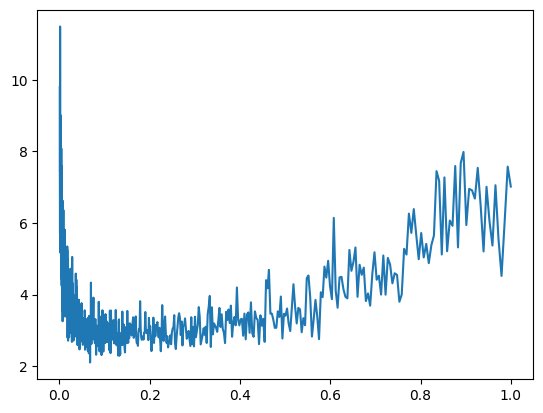

In [244]:
plt.plot(lri, lossi)

Since we took the exponent, we can plot this too and see it is around 10**-1 = 0.1, as we had before

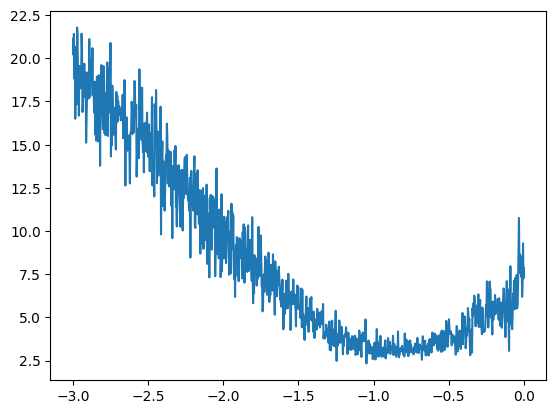

In [254]:
plt.plot(lre, lossi)

Now, with the optimised learning rate, we can set this and crank up the iterations

In [263]:
# First initialise all parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [264]:
import time

s = time.time()

for i in range(40000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.153289556503296  in 9.216681957244873s


We can then decay the learning rate and do a 10k more steps

In [280]:
import time

s = time.time()

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.051004409790039  in 0.25261425971984863s


Previously we had a `2.45` loss for the bi-gram model, so we have dramatically improved on that with a simple MLP.

This however, isn't proven since it has `overfit` on the training set. We need train, val, and test splits in order to make sure this works in correctly in production.

**Train:** Used to optimise the parameters of the model itself

**Val:** Used to optimise the `hyper`parameters of the model e.g. size of layers, regularisation, learning rate etc.

**Test:** Used sparingly as the final performance check of the model. Every time you test the loss on the test set, you also risk training on this as well.

### Split into train, val, and test

In [374]:
def initialise_params():
    # First initialise all parameters
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True

    return C, W1, b1, W2, b2, parameters

In [408]:
from typing import List, Tuple

def build_dataset(words: List[str], block_size: int = 3) -> Tuple[torch.tensor]:
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [409]:
# Train, val, test shuffle
def do_split(words, val_size: float = 0.1, test_size: float = 0.1):
    import random
    
    random.seed(42)
    random.shuffle(words)
    n1 = int((1-val_size-test_size)*len(words))
    n2 = int((1-test_size)*len(words))
    
    Xtr, Ytr = build_dataset(words[:n1])
    Xdev, Ydev = build_dataset(words[n1:n2])
    Xte, Yte = build_dataset(words[n2:])

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [411]:
Xtr, Ytr, Xdev, Ydev, Xte, Yte = do_split(words)

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [412]:
C, W1, b1, W2, b2, parameters = initialise_params()

In [413]:
# Use Xtr and Ytr to train the network now
import time

s = time.time()

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.4865198135375977  in 2.3562498092651367s


In [414]:
# Training loss
emb = C[Xtr] # only grab 32 rows of X randomly 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # and Y also
print(loss.item())

2.476734161376953


In [415]:
# Validation loss
emb = C[Xdev] # only grab 32 rows of X randomly 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # and Y also
print(loss.item())

2.485535144805908


We see now that the network is underfitting i.e. the val loss is ~= the train loss.

This typically means the network is small so the way to get better performance is to increase the size of the network. 

## Increasing the size of the network

Increase the hidden layer size to 300

In [416]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # Increase the hidden layer size to 300
b1 = torch.randn(300, generator=g) # Increase biases to 300
W2 = torch.randn((300, 27), generator=g) # 300 inputs into the final layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [417]:
# We track stats again here
import time

s = time.time()

lossi = []
stepi = []
for i in range(30000): # 30k epochs

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # only grab 32 rows of X randomly 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # and Y also
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.01 # Use optimised loss from before
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.5738883018493652  in 7.274569034576416s


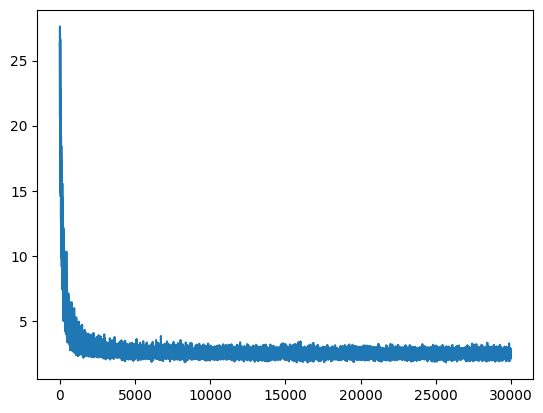

In [418]:
plt.plot(stepi, lossi)

In [419]:
# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4553020000457764


In [420]:
# Val loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.460864305496216


Probably now the bottleneck is the embedding size which is still only 2.

First let's visualise this:

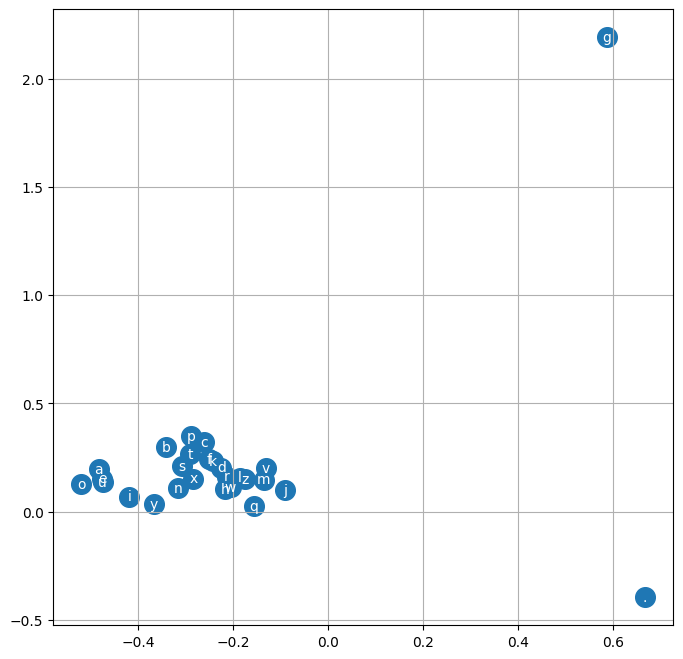

In [421]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

### Increasing the size of the character embeddings

In [422]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 10 dimensional embeddings 
W1 = torch.randn((30, 200), generator=g) # 30 inputs will go into the hidden layer (make it a bit smaller)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [423]:
# Split this out so we get a proper loss curve when running the training multiple times
lossi = []
stepi = []

In [424]:
# We track stats again here
import time

s = time.time()

for i in range(50000): # 50k epochs

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Instead of 6 we now make this 30 (3 context words * 10D embedding size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.01 # Use optimised loss from before but decay after 100k epochs
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  1.9291542768478394  in 12.33743691444397s


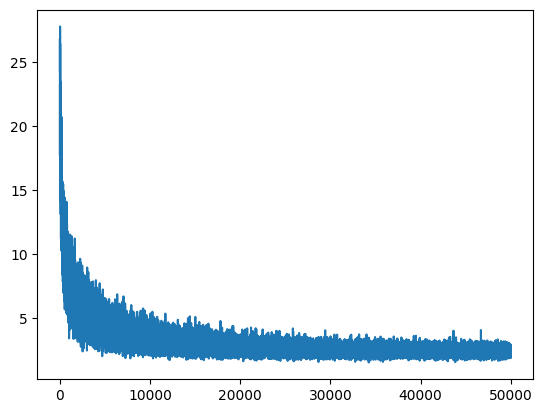

In [425]:
plt.plot(stepi, lossi)

In [426]:
# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.3982186317443848


In [427]:
# Val loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4132559299468994


We usually then run for another 50k epochs after this has run once and decay the learning rate to 0.01 to get a bit closer to optimum.

In production, we would run a bunch of experiments with a large number of hyperparameters in order to optimise this network and kick off all the experiments off in parallel. 

### Run for 200k epochs and decay LR

In [444]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 10 dimensional embeddings 
W1 = torch.randn((30, 200), generator=g) # 30 inputs will go into the hidden layer (make it a bit smaller)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [445]:
# Split this out so we get a proper loss curve when running the training multiple times
lossi = []
stepi = []

In [446]:
# We track stats again here
import time

s = time.time()

for i in range(200000): # 200k epochs

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Instead of 6 we now make this 30 (3 context words * 10D embedding size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01 # Use optimised loss from before but decay after 100k epochs
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

print('Final ', loss.item(), f' in {time.time() - s}s')

Final  2.3014466762542725  in 48.916255235672s


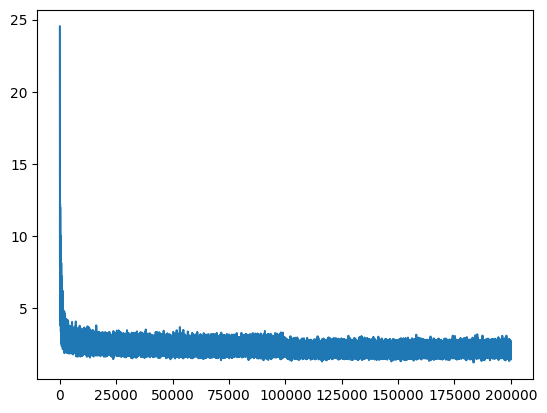

In [447]:
plt.plot(stepi, lossi)

In [448]:
# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.117473840713501


In [449]:
# Val loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1672890186309814


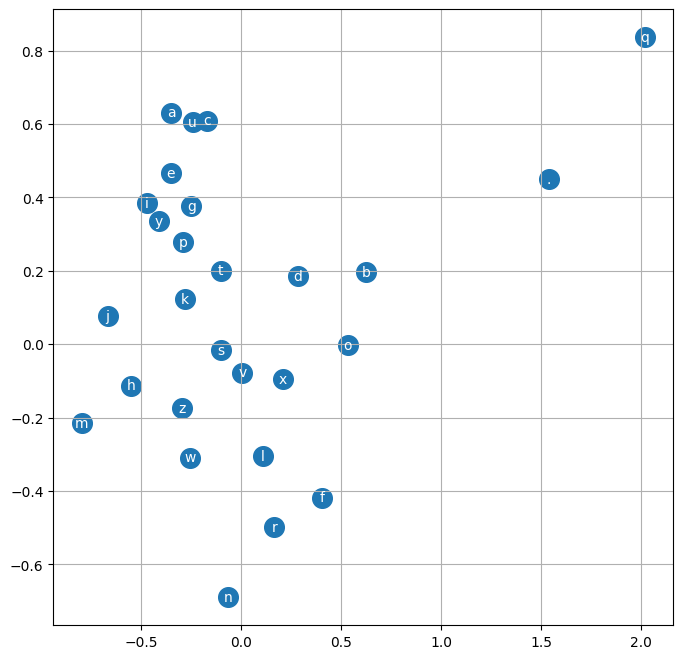

In [450]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Sampling from the model with the trained MLP model

In [462]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialise with all `...`
    # print('NEW-----------')
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        # print('emb: ', emb)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print('probs: ', probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # print('ix: ', ix)
        context = context[1:] + [ix]
        # print('context: ', context)
        out.append(ix)
        if ix == 0:
            # print('out: ', out)
            break
    
    print(''.join([itos[i] for i in out]))

carmahzabelle.
khi.
milia.
aty.
skansha.
jazhebradellah.
jareen.
nellara.
chaiivdy.
leigh.
ham.
join.
quint.
shoilea.
jadiquinzero.
dearynn.
jace.
chruan.
edde.
iia.
